In [13]:
import json
import numpy as np
import scipy.sparse as sparse
from os import listdir
import matplotlib.pyplot as plt

In [9]:
deletion_file = '../deletions_to_validate/ihart_inherited_confident.json'
data_dir = '../split_gen_ihart'

In [10]:
with open(deletion_file, 'r') as f:
    deletions = json.load(f)
print(deletions)

[{'family': 'AU2125.AU2125202.AU2125201', 'chrom': '2', 'start_pos': 145735762, 'end_pos': 147489202, 'length': 1753441, 'phase_length': 3942, 'opt_start_pos': 145735762, 'opt_end_pos': 147489202, 'trans': ['AU2125303', 'AU2125302'], 'notrans': [], 'family_size': 4, 'is_mat': True, 'is_pat': False, 'is_denovo': False, 'mother': 'AU2125202', 'father': 'AU2125201'}, {'family': 'AU0660.AU066001.AU066002', 'chrom': '3', 'start_pos': 2211941, 'end_pos': 2709401, 'length': 497461, 'phase_length': 2094, 'opt_start_pos': 2211941, 'opt_end_pos': 2709401, 'trans': ['AU066005', 'AU066004'], 'notrans': ['AU066003'], 'family_size': 5, 'is_mat': False, 'is_pat': True, 'is_denovo': False, 'mother': 'AU066001', 'father': 'AU066002'}, {'family': 'AU0951.AU0951202.AU0951201', 'chrom': '4', 'start_pos': 27991264, 'end_pos': 28437762, 'length': 446499, 'phase_length': 2170, 'opt_start_pos': 27991264, 'opt_end_pos': 28437762, 'trans': ['AU0951301'], 'notrans': ['AU0951302'], 'family_size': 4, 'is_mat': Tru

In [169]:
deletion_index = 8
deletion = deletions[deletion_index]
fr_left, fr_right = 1000000, 1000000

In [170]:
individuals = [deletion['mother'], deletion['father']] + deletion['trans'] + deletion['notrans']
chrom = deletion['chrom']
start_pos = deletion['start_pos']
end_pos = deletion['end_pos']
print('%s:%d-%d' % (chrom, start_pos, end_pos))

9:28994599-30688235


In [171]:
# read samples
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_id_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])
family_indices = np.array([sample_id_to_index[x] for x in individuals])
    
# load genotypes
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)
is_pass = pos_data[:, 3].astype(bool)
is_in_region = (snp_positions >= start_pos-fr_left) & (snp_positions <= end_pos+fr_right)
print('Sites pulled from vcf:', snp_positions.shape[0])

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[family_indices, :] for gen_file in gen_files])

# only look at snps that PASS GATK filter
A = A[:, is_snp & is_pass & is_in_region]
snp_positions = snp_positions[is_snp & is_pass & is_in_region]

# sparse to dense
A = A.A

Sites pulled from vcf: 3590864


In [172]:
indices = np.any(A[:, 1:] != A[:, :-1], axis=0).tolist() + [True]
print(np.sum(indices))
print(((snp_positions >= start_pos) & (snp_positions <= end_pos))[indices, np.newaxis].shape)
print(A[:, indices].shape)

12741
(12741, 1)
(6, 12741)


In [173]:
family_has_deletion = np.zeros((3, snp_positions.shape[0]))
with open('../deletions_ihart/chr.%s.deletions.json' % chrom, 'r') as f:
    all_deletions = json.load(f)
    for d in all_deletions:
        if deletion['family'] == d['family'] and np.sum((snp_positions >= d['start_pos']) & (snp_positions <= d['end_pos'])):
            print(d)
            if d['is_mat'] and not d['is_denovo']:
                family_has_deletion[0, (snp_positions >= d['start_pos']) & (snp_positions <= d['end_pos'])] += 1
            elif d['is_pat'] and not d['is_denovo']:
                family_has_deletion[1, (snp_positions >= d['start_pos']) & (snp_positions <= d['end_pos'])] += 1
            elif d['is_denovo']:
                family_has_deletion[2, (snp_positions >= d['start_pos']) & (snp_positions <= d['end_pos'])] += 1

{'family': 'AU1858.AU1858202.AU1858201', 'chrom': '9', 'start_pos': 28348237, 'end_pos': 28993948, 'length': 645712, 'phase_length': 2245, 'opt_start_pos': 28348237, 'opt_end_pos': 28993948, 'trans': ['AU1858304', 'AU1858302', 'AU1858301'], 'notrans': ['AU1858303'], 'family_size': 6, 'is_mat': True, 'is_pat': False, 'is_denovo': False, 'mother': 'AU1858202', 'father': 'AU1858201'}
{'family': 'AU1858.AU1858202.AU1858201', 'chrom': '9', 'start_pos': 28994599, 'end_pos': 30688235, 'length': 1693637, 'phase_length': 5315, 'opt_start_pos': 28994599, 'opt_end_pos': 30688235, 'trans': ['AU1858304', 'AU1858302', 'AU1858301'], 'notrans': ['AU1858303'], 'family_size': 6, 'is_mat': True, 'is_pat': False, 'is_denovo': False, 'mother': 'AU1858202', 'father': 'AU1858201'}


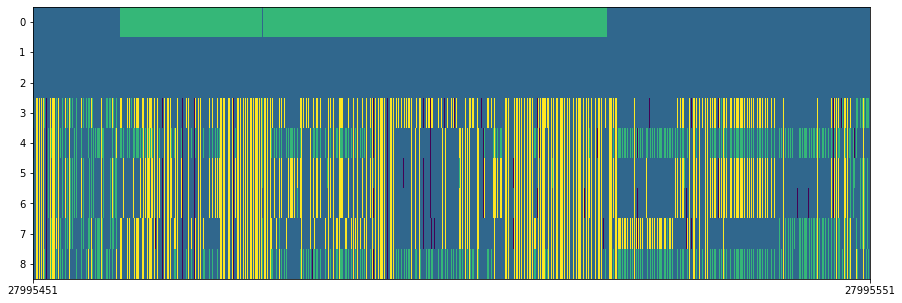

In [174]:
plt.figure(figsize=(15, 5))
indices = np.any(A[:, 1:] != A[:, :-1], axis=0).tolist() + [True]
plt.imshow(np.vstack((family_has_deletion[:, indices],
                      A[:, indices])), 
           aspect='auto', vmin=-1, vmax=2)
plt.xticks(plt.xlim(), [snp_positions[indices][0], snp_positions[indices][1]])
plt.show()

In [175]:
print('is_mat?', deletion['is_mat'], '\ntransmitted to %d children' % len(deletion['trans']))

is_mat? True 
transmitted to 3 children


In [185]:
transitions = np.array([[0.25, 0.00, 0.50, 0.00], 
                     [0.25, 0.00, 0.00, 0.00], 
                     [0.00, 0.50, 0.00, 0.00], 
                     [0.50, 0.50, 0.50, 0.00]])


eigvalues, eigvectors = np.linalg.eig(transitions)

print(eigvalues)
print(eigvectors.astype(float))



[ 0.   +0.j         -0.125+0.33071891j -0.125-0.33071891j
  0.5  +0.j        ]
[[ 0.00000000e+00 -6.32455532e-01 -6.32455532e-01  4.26401433e-01]
 [ 0.00000000e+00  1.58113883e-01  1.58113883e-01  2.13200716e-01]
 [ 0.00000000e+00  4.74341649e-01  4.74341649e-01  2.13200716e-01]
 [ 1.00000000e+00  1.17446762e-16  1.17446762e-16  8.52802865e-01]]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
